In [1]:
#!pip install cvxopt

In [2]:
#!pip install pystruct

In [3]:
# https://github.com/jzbontar/adcensus/tree/master/data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import misc
from skimage.transform import rescale, resize

from scipy.linalg import norm

In [5]:
from skimage.data import stereo_motorcycle

imgageL, imgageR, disparity = stereo_motorcycle()

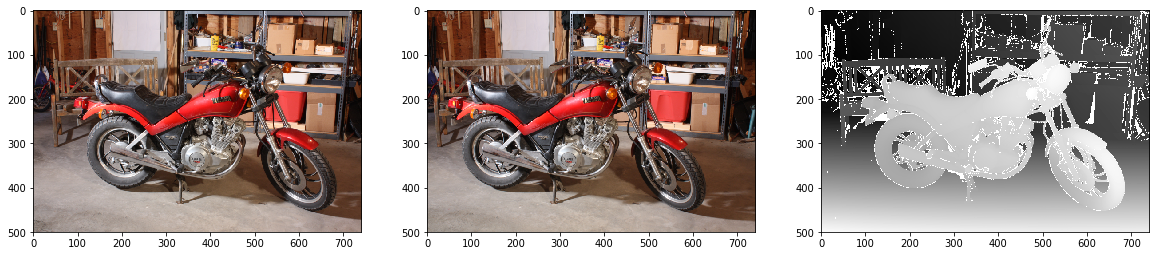

In [7]:
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(imgageL)
plt.subplot(132)
plt.imshow(imgageR)
plt.subplot(133)
plt.imshow(disparity, cmap='gray')
plt.show()

In [8]:
print(np.min(disparity), np.max(disparity))

7.1913557 inf


In [9]:
factor = 0.25
imgL = rescale(imgageL, factor)
imgR = rescale(imgageR, factor)


M,N,_ = imgL.shape 

print(M,N)

125 185


/home/alexey/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/alexey/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/alexey/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [10]:
n_states = 20

N = N - n_states

n_nodes = M*N
n_edges = (M-1)*N + M*(N-1) # M*N-(N+M)



sigma = 20
w = 0.05
tau = 2

y = np.array(range(n_states)).reshape((n_states,1))
d = np.abs(y - y.T)
mask = d <= tau

pairwise = w*(tau*(1 - mask) + mask*d)


unary_potentials = np.zeros((n_nodes, n_states))
pairwise_potentials = pairwise
edges = np.zeros((n_edges, 2), dtype=np.int32)

#unary
for m in range(M):
    for n in range(N):
        for k in range(n_states):
            idx = M*n + m # column-wise order
            unary_potentials[idx,k] = min( sigma, norm(imgL[m,n+k,:] - imgR[m,n,:]) )

# pairwise: vertical
idx = 0
for m in range(M-1):
    for n in range(N):
        edges[idx,0] = M*n + m
        edges[idx,1] = M*n + m + 1
        idx = idx + 1

# pairwise: horizontal
for n in range(N-1):
    for m in range(M):
        edges[idx,0] = M*n + m
        edges[idx,1] = M*n + m + M
        idx = idx + 1


In [11]:
from time import time
from pystruct.inference import inference_dispatch


start = time()
# maximization
y = inference_dispatch(-1.0*unary_potentials, -1.0*pairwise_potentials, edges, inference_method='max-product')
took = time() - start

print('Time, (sec):', took)

Y = y.reshape(N, M).T


Time, (sec): 71.22373676300049


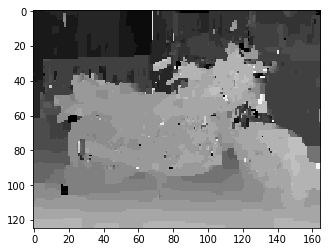

In [12]:
plt.imshow(Y, vmin=0, vmax=n_states, cmap='gray')
plt.show()